# PRÁTICA GUIADA: kNN.

## Introdução

#### Nesta prática, a `kNN` será usada para resolver um problema de classificação.

/* <img src='cover_cluster.jpg'> </img> */

#### Os seguintes passos serão realizados:

1. Carregar o conjunto de dados.
2. Preparar a matriz de recursos e o vetor de targets.
3. Escolher o valor ideal para o hiperparâmetro $k_{neighbours}$, utilizando VALIDAÇÃO CRUZADA.
4. Repetir o processo, porém, padronizando a matriz de recursos para ver os efeitos sobre o algoritmo. 
5. Matriz de confusão.

## 1 - Importar o conjunto de dados.

#### O conjunto de dados `market.csv` contém dados sobre as ações que compõem o índice [`S&P 500`](https://en.wikipedia.org/wiki/S%26P_500) retirado do site do [`Yahoo Finance`](https://finance.yahoo.com/) entre $2000$ e $2001$.

#### A seguir, uma descrição das colunas:

* **Lag1:** Percentage return for previous day
* **Lag2:** Percentage return for 2 days previous
* **Lag3:** Percentage return for 3 days previous
* **Lag4:** Percentage return for 4 days previous
* **Lag5:** Percentage return for 5 days previous
* **Volume:** Volume of shares traded (number of daily shares traded in billions)
* **Today:** Percentage return for today
* **Direction:** A factor with levels Down and Up indicating whether the market had a positive or negative
return on a given day


#### Vamos importar as bibliotecas `pandas` e `numpy` para manipular os dados. Vamos também incluir as bibliotecas:

- [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html), para a seleção dos conjuntos de treino e teste; 
- [`sklearn.neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) para a implementação do modelo de [`kNN`](https://scikit-learn.org/stable/modules/neighbors.html).
- [`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) para a construção da [matriz de confusão](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html), que faz a comparação entre as classificações e os valores reais.

In [182]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

####  <span style = "color:red">Código Original.</span>
<!---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
-->

#### Uma vez carregadas as bibliotecas podemos então ler o arquivo `market.csv`, em anexo. Vamos estudar uma amostra das primeiras linhas do `dataset`.

In [183]:
df = pd.read_csv('market.csv')
#df.sample(5)
df.head()

,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,381.0,-192.0,-2624.0,-1055.0,5.01,1.1913,959.0,Up
1,959.0,381.0,-192.0,-2624.0,-1055.00,1.2965,1032.0,Up
2,1032.0,959.0,381.0,-192.0,-2624.00,1.4112,-623.0,Down
3,-623.0,1032.0,959.0,381.0,-192.00,1276.0000,614.0,Up
4,614.0,-623.0,1032.0,959.0,381.00,1.2057,213.0,Up


####  <span style = "color:red">Código Original.</span>
<!---
df = pd.read_csv('market.csv')
df.sample(5)
-->

In [184]:
df.shape

(1250, 8)

## 2 - Construir a matriz de recursos e o vetor de targets.

#### O próximo passo é o de definir uma matriz com os atributos que servirão como recursos para a classificação dos `targets`. As colunas que temos disponíveis são as seguintes.

In [185]:
df.columns

Index(['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today', 'Direction'], dtype='object')

####  <span style = "color:red">Código Original.</span>
<!---
df.columns
-->

#### Vamos tomar os atributos `['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']` do `dataset` `df` para classificar nosso `target`, para isso instanciamos um objeto `X` que recebe as colunas sugeridas.

In [186]:
# Construir a matriz de recursos, subconfigurando o DataFrame para que não contenha a classe, Direction
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']]

####  <span style = "color:red">Código Original.</span>
<!---
# Construir a matriz de recursos, subconfigurando o DataFrame para que não contenha a classe, Direction
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']]
-->

### Tornando numérico o vetor de targets.

#### O vetor de `targets` foi codificado com os valores possíveis de `'Up'` ou `'Down'`, mas lembre-se que `scikitlearn` só aceita valores numéricos (mesmo que eles representem classes), portanto, temos que codificar as classes como `tags` [numéricas](https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd). Para isso vamos utilizar:

- O pacote [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) que oferece várias funções utilitárias comuns e classes de transformadores para alterar vetores de recursos brutos em uma representação mais adequada para os estimadores.

- Específicamente, vamos instanciar um objeto `le` que receberá a função de codificação [`.LabelEncoder()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html), que codifica os rótulos de destino com valor entre $0$ e $n_{classes-1}$.

- Então, instanciamos um objeto `y` que recebe o objeto `le`, submetido ao método [`.fit_transform()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder.fit_transform), que ajusta o codificador dos rótulos do target e retorna os rótulos originais sob anova codificacão.

In [187]:
# Construir o vetor de targets
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Direction'])
y

array([1, 1, 0, ..., 1, 0, 0])

####  <span style = "color:red">Código Original.</span>
<!---
# Construir o vetor de targets
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['Direction'])
y
-->

## 3 - Avaliar diferentes valores para o hiperparâmetro `k`.

#### Vamos executar o modelo [`KNeighborsClassifier`](https://ogrisel.github.io/scikit-learn.org/sklearn-tutorial/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) testando diferentes valores possíveis para o hiperparâmetro $k_{neighbors}$.

#### Para realizar a classificação dos targets vamos precisar realizar:

- A importação da biblioteca [`sklearn.model_selection.cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), que avalia e gera uma pontuação para a validação cruzada.

- A aplicação da função [`KNeighborsClassifier()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), que desempenha a função de classificador, implementando os votos para os 'k'-vizinhos mais próximos. Os `k` vizinhos mais próximos representa um modelo de classificação, que será instanciado em um objeto `model`. observe o parâmetro `n_neighbors`, que recebe o número de vizinhos a serem usados.

- A função [`cross_val_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), que deve ser aplicada às matrizes `X` e `y` e ao objeto `model`, para realizar as dobras nos dados de treino e a avaliação da pontuação por validação cruzada. Para isso instanciamos esse processo em um objeto `cv_scores`.

#### Podemos imbutir esse processo em um `loop` sobre um arranjo de valores para o número de vizinhos `n_neighbors`. Ao fim de cada ciclo um dicionário `dict_row_score` recebe os valores da média e desvio padrão de `cv_scores` e do número `i` de vizinhos associados. Ao fim, o `loop` cria uma lista de dicionários a ser manipulada.

In [188]:
from sklearn.model_selection import cross_val_score

# Queremos representar graficamente os diferentes valores de score de validação cruzada em função do hiperparâmetro k_neighbors
# Para isso, vamos gerar uma lista de dicionários que depois podem ser facilmente convertidos em um DataFrame.

#Lista de Dicionários
scores_para_df = []

error_rates = {}

# range(1,40,5) são os valores possíveis de n_neighbors que queremos explorar. São todos os inteiros de 1
# a 40, de 5 em 5. (Start,Stop,Step)
for i in range(1, 100, 5):
    
    # Em cada iteração, instanciar o modelo com um hiperparâmetro diferente
    model = KNeighborsClassifier(n_neighbors = i)
    
    # cross_val_scores retorna um array de 5 resultados, um para cada partição feita automaticamente pelo CV  
    cv_scores = cross_val_score(model, 
                                X, 
                                y, 
                                cv = 5
                               )

    # Para cada valor de n_neighbours, criar um dicionário com o valor de n_neighbours, a média e o desvio dos scores.
    dict_row_score = {'score_medio':np.mean(cv_scores), 
                      'score_std':np.std(cv_scores),
                      'n_neighbours': i
                     }
    
    # Guardar cada um na lista de dicionários
    scores_para_df.append(dict_row_score)
    
    error = 1 - np.mean(cross_val_score(model, 
                                        X, 
                                        y, 
                                        cv = 5
                                       )
                       )
    error_rates.update({i: error})

#### Fazemos uma [validação cruzada](https://scikit-learn.org/stable/modules/cross_validation.html) para estimar o parâmetro `k` (número de vizinhos próximos) do algoritmo. Salvamos os valores do erro de classificação 

$$
error = 1 - \overline{cross~val~score}, 
$$ 

#### guardamos em um dicionário e procuramos o valor mínimo (ou seja, o erro mínimo de classificação).

In [189]:
error_rates

{1: 0.4992,
 6: 0.5168,
 11: 0.49119999999999997,
 16: 0.49839999999999995,
 21: 0.48639999999999994,
 26: 0.49119999999999997,
 31: 0.49439999999999995,
 36: 0.48239999999999994,
 41: 0.4663999999999999,
 46: 0.4616,
 51: 0.45999999999999996,
 56: 0.472,
 61: 0.47439999999999993,
 66: 0.47519999999999996,
 71: 0.48239999999999994,
 76: 0.49039999999999995,
 81: 0.49439999999999995,
 86: 0.4776,
 91: 0.4623999999999999,
 96: 0.46399999999999997}

In [197]:
kBest = min(error_rates, key = error_rates.get)
kBest

51

####  <span style = "color:red">Código Original.</span>
<!---
from sklearn.model_selection import cross_val_score

# Queremos representar graficamente os diferentes valores de score de validação cruzada em função do hiperparâmetro k_neighbors
# Para isso, vamos gerar uma lista de dicionários que depois podem ser facilmente convertidos em um DataFrame.

#Lista de Dicionários
scores_para_df = []

# range(1,40,5) são os valores possíveis de n_neighbors que queremos explorar. São todos os inteiros de 1
# a 40, de 5 em 5. (Start,Stop,Step)
for i in range(1,100,5):
    # Em cada iteração, instanciar o modelo com um hiperparâmetro diferente
    model = KNeighborsClassifier(n_neighbors = i)
    
    # cross_val_scores retorna um array de 5 resultados, um para cada partição feita automaticamente pelo CV  
    cv_scores = cross_val_score(model, 
                                X, 
                                y, 
                                cv = 5
                               )
    
    # Para cada valor de n_neighbours, criar um dicionário com o valor de n_neighbours, a média e o desvio dos scores.
    dict_row_score = {'score_medio':np.mean(cv_scores), 
                      'score_std':np.std(cv_scores),
                      'n_neighbours':i
                     }
    
    # Guardar cada um na lista de dicionários
    scores_para_df.append(dict_row_score)
    

-->

#### Uma vez que a lista de dicionários está terminada, a convertemos em um `dataframe` que examinamos.

In [193]:
# Criar o DataFrame a partir da lista de dicionários
df_scores = pd.DataFrame(scores_para_df)
df_scores.head(20)

,score_medio,score_std,n_neighbours
0,0.5008,0.047288,1
1,0.4832,0.024580,6
2,0.5088,0.031840,11
3,0.5016,0.026845,16
4,0.5136,0.023947,21
5,0.5088,0.033505,26
6,0.5056,0.026605,31
7,0.5176,0.039968,36
8,0.5336,0.017454,41
9,0.5384,0.022712,46


####  <span style = "color:red">Código Original.</span>
<!---
# Criar o DataFrame a partir da lista de dicionários
df_scores = pd.DataFrame(scores_para_df)
df_scores.head()
-->

### Representando graficamente a procura pelo melhor hiperparâmetro

#### O valor de pontuação que utiliza [`KNeighborsClassifier`](https://towardsdatascience.com/k-nearest-neighbors-94395f445221) por padrão é o `accuracy`: <br>

$$
\text{acurácia} = \frac{\text{Casos bem classificados}}{\text{Total}}
$$    

#### Uma vez que temos o `DataFrame` com o desempenho de cada valor do hiperparâmetro, fazemos um gráfico com os valores. Para ter uma ideia da dispersão, também representamos graficamente as linhas que indicam um desvio padrão acima e abaixo da média.

#### Vamos calcular um limite superior e um inferior para os `scores` das validações cruzadas, em termos da média e dos valores e do desvio padrão, adicionado e subtraído à média dos `scores`.

In [194]:
df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']

####  <span style = "color:red">Código Original.</span>
<!---
df_scores['limite_inferior'] = df_scores['score_medio'] - df_scores['score_std']
df_scores['limite_superior'] = df_scores['score_medio'] + df_scores['score_std']
-->

#### Como atribuímos os limites a novas colunas no `dataframe` original, teremos como `.head()`:

In [195]:
df_scores.head()

,score_medio,score_std,n_neighbours,limite_inferior,limite_superior
0,0.5008,0.047288,1,0.453512,0.548088
1,0.4832,0.024580,6,0.458620,0.507780
2,0.5088,0.031840,11,0.476960,0.540640
3,0.5016,0.026845,16,0.474755,0.528445
4,0.5136,0.023947,21,0.489653,0.537547


####  <span style = "color:red">Código Original.</span>
<!---
df_scores.head()
-->

#### Usando a biblioteca [`matplotlib.pyplot`](https://matplotlib.org/3.3.4/api/_as_gen/matplotlib.pyplot.html) podemos traçar as curvas para o número de vizinhos `'n_neighbours'` em função dos atributos: 

- `'limite_inferior'`;
- `'score_medio'`; 
- `'limite_superior'`.

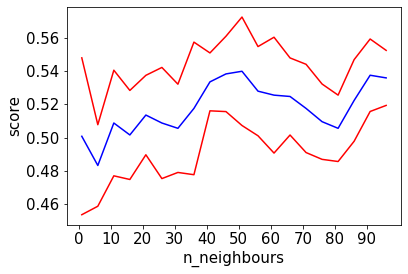

In [196]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 15})

plt.plot(df_scores['n_neighbours'], 
         df_scores['limite_inferior'], 
         color = 'r'
        )
plt.plot(df_scores['n_neighbours'], 
         df_scores['score_medio'], 
         color = 'b'
        )
plt.plot(df_scores['n_neighbours'], 
         df_scores['limite_superior'], 
         color = 'r'
        )

n_neighbours = 100
plt.xlabel('n_neighbours')
plt.ylabel('score')
plt.xticks(np.arange(0, n_neighbours, step = 10));

####  <span style = "color:red">Código Original.</span>
<!---
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_scores['n_neighbours'],df_scores['limite_inferior'],color='r')
plt.plot(df_scores['n_neighbours'],df_scores['score_medio'],color='b')
plt.plot(df_scores['n_neighbours'],df_scores['limite_superior'],color='r');
-->

## 4 - Padronização das variáveis

#### O [kNN](https://scikit-learn.org/stable/modules/neighbors.html) é um método de Machine Learning que se baseia em [medições de distância](https://medium.com/@luigi.fiori.lf0303/distance-metrics-and-k-nearest-neighbor-knn-1b840969c0f4), aqui consideramos para nosso modelo os atributos

- `['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']`.

#### Para dar maior interpretabilidade matemática ao processo que está sendo feito, o correto seria padronizar as variáveis para se desfazer das unidades físicas.

#### Vamos então importar a biblioteca [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/preprocessing.html) e aplicar a função de reescalonamento [`preprocessing.scale()`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html) aos atributos: 

In [202]:
# Utilizar sklearn para padronizar a matriz de Features
from sklearn import preprocessing
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']]
X = preprocessing.scale(X, 
                        axis = 0
                       )
print(X)

[[ 3.48481977e-01 -1.79255809e-01 -2.41127773e+00 -9.69640067e-01
   4.19212790e-03]
 [ 8.80742814e-01  3.48410092e-01 -1.76909384e-01 -2.41104053e+00
  -9.69612732e-01]
 [ 9.47966069e-01  8.80680406e-01  3.49526907e-01 -1.76823880e-01
  -2.41101406e+00]
 ...
 [-8.81795667e-01  3.71516723e-02  3.87195123e-01  2.31067647e-01
  -2.24586386e-02]
 [-2.24844658e-03 -8.81889459e-01  3.89938068e-02  3.87242330e-01
   2.31095706e-01]
 [-2.76786376e-01 -2.32657749e-03 -8.77905702e-01  3.90646534e-02
   3.87270484e-01]]


####  <span style = "color:red">Código Original.</span>
<!---
# Utilizar sklearn para padronizar a matriz de Features
from sklearn import preprocessing
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']]
X = preprocessing.scale(X, axis = 0)
-->

#### Podemos calcular as médias e desvios padão para cada atributo padronizado.

In [203]:
# Verificar se as colunas têm média 0 e desvio 1.
print('media:', np.mean(X[:,4]))
print('desvio:', np.std(X[:,4]))

media: -8.526512829121201e-18
desvio: 0.9999999999999999


####  <span style = "color:red">Código Original.</span>
<!---
# Verificar se as colunas têm média 0 e desvio 1.
print('media:',np.mean(X[:,1]))
print('desvio:',np.std(X[:,1]))
-->

#### Agora vamos repetir o processo de validação cruzada dos dados, uma vez que realizaremos o processo em dados padronizados.

#### Vamos novamente rodar um `loop` sobre diversos valores possíveis de número de vizinhos, e calcular as médias e desvios padrão dos `scores` da validação cruzada, guandando-os em uma nova lista de dicionários.

In [205]:
# Calcular os scores de validação cruzada novamente, mas desta vez sobre os recursos padronizados
from sklearn.model_selection import cross_val_score

scores_para_df_standar = []

error_rates = {}

for i in range(1, 100, 5):
    
    model = KNeighborsClassifier(n_neighbors = i)
    
    cv_scores = cross_val_score(model, 
                                X, 
                                y, 
                                cv = 5
                               )
    
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores),
                      'n_neighbours':i
                     }
    scores_para_df_standar.append(dict_row_score)
    
    error = 1 - np.mean(cross_val_score(model, 
                                        X, 
                                        y, 
                                        cv = 5
                                       )
                       )
    error_rates.update({i:error})

####  <span style = "color:red">Código Original.</span>
<!---
# Calcular os scores de validação cruzada novamente, mas desta vez sobre os recursos padronizados
from sklearn.model_selection import cross_val_score

scores_para_df_standar = []

for i in range(1,100,5):
    model = KNeighborsClassifier(n_neighbors = i)
    
    cv_scores = cross_val_score(model, 
                                X, 
                                y, 
                                cv = 5
                               )
    
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores),'n_neighbours':i
                     }
    scores_para_df_standar.append(dict_row_score)
-->

#### Fazemos novamente uma validação cruzada para estimar o parâmetro `k` (número de vizinhos próximos) do algoritmo. Salvamos os valores do erro de classificação ($1 - \overline{cross~val~score}$), guardamos em um dicionário e procuramos o valor mínimo (ou seja, o erro mínimo de classificação).

In [206]:
error_rates

{1: 0.4992,
 6: 0.5184,
 11: 0.48960000000000004,
 16: 0.49839999999999995,
 21: 0.488,
 26: 0.49039999999999995,
 31: 0.49439999999999995,
 36: 0.48319999999999996,
 41: 0.4663999999999999,
 46: 0.45919999999999994,
 51: 0.45999999999999996,
 56: 0.4728,
 61: 0.476,
 66: 0.4776,
 71: 0.48160000000000003,
 76: 0.4888,
 81: 0.49439999999999995,
 86: 0.47919999999999996,
 91: 0.46319999999999995,
 96: 0.4648}

In [214]:
kBest = min(error_rates, key = error_rates.get)
kBest

46

#### Convertemos a nova lista de dicionários em um dataframe.

In [208]:
df_scores_standar = pd.DataFrame(scores_para_df_standar)
df_scores_standar

,score_medio,score_std,n_neighbours
0,0.5008,0.047288,1
1,0.4816,0.024344,6
2,0.5104,0.035472,11
3,0.5016,0.028689,16
4,0.5120,0.025675,21
5,0.5096,0.032060,26
6,0.5056,0.028800,31
7,0.5168,0.040509,36
8,0.5336,0.017270,41
9,0.5408,0.023379,46


####  <span style = "color:red">Código Original.</span>
<!---
df_scores_standar = pd.DataFrame(scores_para_df_standar)
df_scores_standar.head()
-->

#### Ainda repetindo o processo, vamos novamente criar intervalos mínimos e máximos para os `scores` das validações cruzadas, em termos das médias adicionadas e subtraídas de um desvio padrão.

In [209]:
# Criar os limites para representação gráfica novamente
df_scores_standar['limite_superior'] = df_scores_standar['score_medio'] + df_scores_standar['score_std']
df_scores_standar['limite_inferior'] = df_scores_standar['score_medio'] - df_scores_standar['score_std']

####  <span style = "color:red">Código Original.</span>
<!---
# Criar os limites para representação gráfica novamente
df_scores_standar['limite_superior'] = df_scores_standar['score_medio'] + df_scores_standar['score_std']
df_scores_standar['limite_inferior'] = df_scores_standar['score_medio'] - df_scores_standar['score_std']
-->

#### Realizando uma nova plotagem do número de vizinhos `'n_neighbours'` em função dos atributos: 
* `'limite_inferior'`;
* `'score_medio'`; 
* `'limite_superior'`.

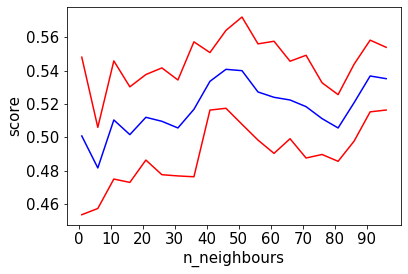

In [210]:
# Buscar graficamente o valor ideal para n_neighbors
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams.update({'font.size': 15})

plt.plot(df_scores_standar['n_neighbours'], 
         df_scores_standar['limite_inferior'], 
         color = 'r'
        )
plt.plot(df_scores_standar['n_neighbours'], 
         df_scores_standar['score_medio'], 
         color = 'b'
        )
plt.plot(df_scores_standar['n_neighbours'], 
         df_scores_standar['limite_superior'], 
         color = 'r'
        )

n_neighbours = 100
plt.xlabel('n_neighbours')
plt.ylabel('score')
plt.xticks(np.arange(0, n_neighbours, step = 10));

####  <span style = "color:red">Código Original.</span>
<!---
# Buscar graficamente o valor ideal para n_neighbors
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['limite_inferior'],color = 'r')
plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['score_medio'],color = 'b')
plt.plot(df_scores_standar['n_neighbours'],df_scores_standar['limite_superior'],color = 'r');
-->

#### Avaliando os resultados

#### Neste caso, vemos que a padronização gera uma alteração nos resultados do modelo? 

* Por que observamos isso?


####  <span style = "color:red">Código Original.</span>
<!---
* Porque neste modelo todas as variáveis são expressas nas mesmas unidades, por isso, não é necessário redimensionar cada um dos componentes para construir uma matriz de distância que faça sentido.
-->

## 5 - Matriz de confusão

#### Agora que foi decidido qual é o melhor pré-processamento e o melhor valor possível para os hiperparâmetros, é possível treinar um modelo com esses critérios para obter uma matriz de confusão sobre os dados não observados. 

### 5.1- Pré-processamento dos dados.

#### Vamos repetir os passos acima apenas para tornar todo o processo mais claro.

#### Reescalonamos os atributos escolhidos com `preprocessing.scale()` e realizamos a codificação dos targets com a função `preprocessing.LabelEncoder()`.

#### Ajustamos os `targets` codificados ao atributo `'Direction'`.

In [211]:
# Matriz de features
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']]
X = preprocessing.scale(X, 
                        axis = 0
                       )
# Vetor de targets
le = preprocessing.LabelEncoder()

y = le.fit_transform(df['Direction'])

print(y)

[1 1 0 ... 1 0 0]


####  <span style = "color:red">Código Original.</span>
<!---
# Matriz de features
X = df[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5']]
X = preprocessing.scale(X, axis = 0)

# Vetor de targets
le = preprocessing.LabelEncoder()

y = le.fit_transform(df['Direction'])

print(y)
-->

### 5.2- Split train-test.

#### Já sabendo qual é o melhor modelo, queremos obter uma matriz de confusão. 

#### Vamos fazer um novo `split train-test` porque sempre queremos avaliar onde o modelo faz previsões corretas e onde ele comete erros sobre dados não observados.

#### Aplicamos novamente a função  `train_test_split()` aos objetos `X` com os atributos e `y` com os `targets`.

In [212]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

####  <span style = "color:red">Código Original.</span>
<!---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)
-->

#### Agora instanciamos o objeto `model` que receberá o modelo dos k vizinhos mais próximos `KNeighborsClassifier()` e ajustamos esse modelo aos dados de treino.

In [215]:
# Escolher o modelo ideal que foi indicado pela validação cruzada
#model = KNeighborsClassifier(n_neighbors = 26)
model = KNeighborsClassifier(n_neighbors = kBest)

# Ajustá-lo sobre os dados de treinamento
model.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=46)

####  <span style = "color:red">Código Original.</span>
<!---
# Escolher o modelo ideal que foi indicado pela validação cruzada
model = KNeighborsClassifier(n_neighbors = 26)

# Ajustá-lo sobre os dados de treinamento
model.fit(X_train,y_train)
-->

#### Podemos então fazer a previsão da condição de `up` ou `down` para o atributo target `'Direction'`.

In [216]:
# Ele é utilizado para prever em teste
y_pred = model.predict(X_test)

####  <span style = "color:red">Código Original.</span>
<!---
# Ele é utilizado para prever em teste
y_pred = model.predict(X_test)
-->

#### Agora, importando a biblioteca [`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html), podemos calcular a matrix de confusão entre os subconjuntos `y_test` e `y_pred`.

In [217]:
# Elaborar a matriz de confusão:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)

array([[ 62,  67],
       [ 79, 105]])

####  <span style = "color:red">Código Original.</span>
<!---
# Elaborar a matriz de confusão:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)
-->

#### Poremos importar a matriz de confusão para um mapa de calor, com a função [`sns.heatmap()`](https://seaborn.pydata.org/generated/seaborn.heatmap.html) da biblioteca `seaborn`.

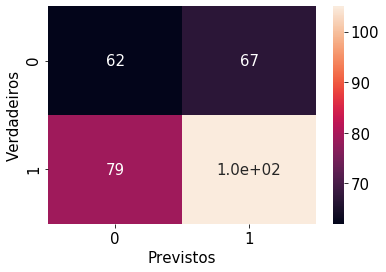

In [218]:
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, 
                             y_pred
                            ),
            annot = True
           )
plt.ylabel('Verdadeiros')
plt.xlabel('Previstos');

####  <span style = "color:red">Código Original.</span>
<!---
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, y_pred))
plt.ylabel('Verdadeiros')
plt.xlabel('Previstos');
-->

#### Lembrando que as classes previstas são `['Down', 'Up']`.

In [220]:
# Lembrar dos valores dos rótulos que foram criados com o método LabelEncoder()
le.classes_

array(['Down', 'Up'], dtype=object)

####  <span style = "color:red">Código Original.</span>
<!---
le.classes_
-->

#### Conclusão: Não parece ser fácil prever a evolução das ações com base nos recursos utilizados. O modelo tem um viés para prever que as ações vão subir. 

#### Calculamos a acuácia com a função [`accuracy_score()`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html).

In [222]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.5335463258785943

#### Calculamos a precisão com a função [`precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html)

In [223]:
from sklearn.metrics import precision_score
precision_score(y_test, y_pred)

0.6104651162790697

#### E calculamos a precisão com a função  [`recall_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html).

In [224]:
from sklearn.metrics import recall_score
recall_score(y_test, y_pred)

0.5706521739130435

##  <span style = "color:blue">Prática Independente.</span>
<!---
-->

#### Agora pratique a classificação de casos de câncer de próstata com o arquivo anexo `'cancer-prostate.csv'`, nele você encontrará informações sobre:

- `'id'`, 
- `'diagnosis_result'`
- `'radius'`
- `'texture'` 
- `'perimeter'`
- `'area'`
- `'smoothness'`
- `'compactness'` 
- `'symmetry'`
- `'fractal_dimension'`

####  <span style = "color:red">Código Original.</span>
<!---
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
-->

####  <span style = "color:red">Código Original.</span>
<!---
df = pd.read_csv('cancer-prostate.csv')
df.sample(5)
-->

####  <span style = "color:red">Código Original.</span>
<!---
df.columns
#df.shape
-->

#### Realize o reescalonamento dos atributos descritivos e a codificação dos targets, ajustando-os para se submeterem à separação entre conjuntos de treino e teste. Calcule o melhor valor para o número de vizinhos através da observação do menor resíduo.

####  <span style = "color:red">Código Original.</span>
<!---
# Matriz de atributos descritivos
X = df[['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness', 'symmetry', 'fractal_dimension']]
X = preprocessing.scale(X, axis = 0)

# Vetor de targets
le = preprocessing.LabelEncoder()
y = le.fit_transform(df['diagnosis_result'])
print(y)
-->

####  <span style = "color:red">Código Original.</span>
<!---
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)
-->

####  <span style = "color:red">Código Original.</span>
<!---
# Calcular os scores de validação cruzada novamente, mas desta vez sobre os recursos padronizados
from sklearn.model_selection import cross_val_score

scores_para_df_standar = []

error_rates = {}

for i in range(1, 50, 5):
    
    model = KNeighborsClassifier(n_neighbors = i)
    
    cv_scores = cross_val_score(model, 
                                X, 
                                y, 
                                cv = 5
                               )
    
    dict_row_score = {'score_medio':np.mean(cv_scores),
                      'score_std':np.std(cv_scores),
                      'n_neighbours':i
                     }
    scores_para_df_standar.append(dict_row_score)
    
    error = 1 - np.mean(cross_val_score(model, X, y, cv = 5))
    error_rates.update({i:error})
-->

####  <span style = "color:red">Código Original.</span>
<!---
error_rates
kneighbors = min(error_rates, key = error_rates.get)
kneighbors
-->

#### Depois disso instancie um objeto para receber o modelo de kNN e ajuste os dados de treino. 

####  <span style = "color:red">Código Original.</span>
<!---
# Escolher o modelo ideal que foi indicado pela validação cruzada

model = KNeighborsClassifier(n_neighbors = kneighbors)

# Ajustá-lo sobre os dados de treinamento
model.fit(X_train, y_train)
-->

####  <span style = "color:red">Código Original.</span>
<!---
# Ele é utilizado para prever em teste
y_pred = model.predict(X_test)
-->

#### Faça suas previsões e construa uma matriz de confusão para checar a acurácia de seu modelo, crie um mapa de calor para confrontrar os valores previstos com os observados.

####  <span style = "color:red">Código Original.</span>
<!---
# Elaborar a matriz de confusão:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred)
-->

####  <span style = "color:red">Código Original.</span>
<!---
import seaborn as sns

sns.heatmap(confusion_matrix(y_test, 
                             y_pred
                            ),
            annot = True
           )
plt.ylabel('Verdadeiros')
plt.xlabel('Previstos');
-->

####  <span style = "color:red">Código Original.</span>
<!---
# Lembrar dos valores dos rótulos que foram criados com o método LabelEncoder()
le.classes_
-->

####  <span style = "color:blue">Código Original.</span>
<!---
[``]()
-->